In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType, col, when, max, rand, hour, minute, expr, min
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from functools import reduce

In [2]:
spark = SparkSession.builder.appName('123').getOrCreate()

In [5]:
#Reading the file now
data_o = spark.read.csv('/mnt/bdpa23-group14-pvc/dl_data.csv', header=True,
inferSchema=True)

KeyboardInterrupt: 

In [4]:
data = data_o

NameError: name 'data_o' is not defined

In [4]:
data.dtypes

[('Visit_Number_Bucket', 'string'),
 ('Page_Views_Normalized', 'double'),
 ('Orders_Normalized', 'int'),
 ('Internal_Search_Successful_Normalized', 'double'),
 ('Internal_Search_Null_Normalized', 'double'),
 ('Email_Signup_Normalized', 'double'),
 ('Total_Seconds_Spent_Normalized', 'double'),
 ('Store_Locator_Search_Normalized', 'double'),
 ('Mapped_Last_Touch_Channel', 'string'),
 ('Mapped_Mobile_Device_Type', 'string'),
 ('Mapped_Browser_Type', 'string'),
 ('Mapped_Entry_Pages', 'string'),
 ('Mapped_Site_Section', 'string'),
 ('Mapped_Promo_Code', 'string'),
 ('Maped_Product_Name', 'string'),
 ('Mapped_Search_Term', 'string'),
 ('Mapped_Product_Collection', 'string')]

In [5]:
unique_strings = [row[0] for row in data.select("Orders_Normalized").distinct().collect()]
print(unique_strings)

[1, 0]


In [7]:
print(data.filter(col("Orders_Normalized") == 0).count())
print(data.filter(col("Orders_Normalized") == 1).count())

38030
35457


In [11]:
col_names = get_col_names(data)
print(col_names)
for name in col_names:
    col_name = name[0]
    unique_strings = [row[0] for row in data.select(col_name).distinct().collect()]
    max_value = data.select(max(col_name)).collect()[0][0]
    min_value = data.select(min(col_name)).collect()[0][0]
    print(f"Column {col_name} has {len(unique_strings)} unique strings! Max = {max_value}, Min = {min_value}")
    

[('Visit_Number_Bucket', 'string'), ('Page_Views_Normalized', 'double'), ('Orders_Normalized', 'int'), ('Internal_Search_Successful_Normalized', 'double'), ('Internal_Search_Null_Normalized', 'double'), ('Email_Signup_Normalized', 'double'), ('Total_Seconds_Spent_Normalized', 'double'), ('Store_Locator_Search_Normalized', 'double'), ('Mapped_Last_Touch_Channel', 'string'), ('Mapped_Mobile_Device_Type', 'string'), ('Mapped_Browser_Type', 'string'), ('Mapped_Entry_Pages', 'string'), ('Mapped_Site_Section', 'string'), ('Mapped_Promo_Code', 'string'), ('Maped_Product_Name', 'string'), ('Mapped_Search_Term', 'string'), ('Mapped_Product_Collection', 'string')]
Column Visit_Number_Bucket has 8 unique strings!
Column Page_Views_Normalized has 27 unique strings!
Column Orders_Normalized has 2 unique strings!
Column Internal_Search_Successful_Normalized has 9 unique strings!
Column Internal_Search_Null_Normalized has 5 unique strings!
Column Email_Signup_Normalized has 5 unique strings!
Column T

In [6]:
data.printSchema()

root
 |-- Visit_Number_Bucket: string (nullable = true)
 |-- Page_Views_Normalized: double (nullable = true)
 |-- Orders_Normalized: integer (nullable = true)
 |-- Internal_Search_Successful_Normalized: double (nullable = true)
 |-- Internal_Search_Null_Normalized: double (nullable = true)
 |-- Email_Signup_Normalized: double (nullable = true)
 |-- Total_Seconds_Spent_Normalized: double (nullable = true)
 |-- Store_Locator_Search_Normalized: double (nullable = true)
 |-- Mapped_Last_Touch_Channel: string (nullable = true)
 |-- Mapped_Mobile_Device_Type: string (nullable = true)
 |-- Mapped_Browser_Type: string (nullable = true)
 |-- Mapped_Entry_Pages: string (nullable = true)
 |-- Mapped_Site_Section: string (nullable = true)
 |-- Mapped_Promo_Code: string (nullable = true)
 |-- Maped_Product_Name: string (nullable = true)
 |-- Mapped_Search_Term: string (nullable = true)
 |-- Mapped_Product_Collection: string (nullable = true)



In [8]:
#functions
def get_string_mapping(col_name, dataframe):
    print("Getting mapping")
    unique_strings = [row[0] for row in dataframe.select(col_name).distinct().collect()]
    mapping = dict(zip(unique_strings, range(len(unique_strings))))
    return mapping

def get_embedding(col_name, mapping, dataframe):
    print("Getting embedding")
    when_expr = reduce(lambda a, b: a.when(dataframe[col_name] == b, mapping[b]),
                       mapping, when(dataframe[col_name].isNull(), None))
    dataframe = dataframe.withColumn(col_name + "_embedded", when_expr)
    dataframe = dataframe.drop(col_name)
    dataframe = dataframe.withColumnRenamed(col_name + "_embedded", col_name)
    return dataframe

def normalize_column(col_name, dataframe):
    print("Normalizing")
    max_value = dataframe.select(max(col_name)).collect()[0][0]
    dataframe = dataframe.withColumn(f"{col_name}_normalized", expr("{} / {}".format(col_name, max_value))).drop(col_name)
    dataframe = dataframe.withColumnRenamed(col_name + "_normalized", col_name)
    return dataframe 

def embed_time(df):
    print("Embedding time")
    # Convert to seconds since midnight
    df = df.withColumn('Time', hour('Time') * 3600 + minute('Time') * 60)
    return df

def get_col_names(df):
    col_names = []
    for col in df.dtypes:
        col_names.append((col[0], col[1]))
    return col_names

def handle_dataframe(df):
    df_cols = get_col_names(df)
    print("Starting dataframe handling")
    for col in df_cols:
        col_name = col[0]
        if col_name == "Orders_Normalized":
            df = df.withColumnRenamed("Orders_Normalized", "label")
        else:
            print(f"Handling {col_name}")
            if col[1] == 'string':
                if col_name == "Time":
                    df = embed_time(df)
                else:
                    mapping = get_string_mapping(col_name, df)
                    df = get_embedding(col_name, mapping, df)
            df = normalize_column(col_name, df)
    return df

In [66]:
data = data.drop("Mapped_Last_Touch_Channel")

In [76]:
data = data.withColumnRenamed("Orders_Normalized", "label")

In [47]:
data = handle_dataframe(data)

Starting dataframe handling
Handling Visit_Number_Bucket
Getting mapping
Getting embedding
Normalizing
Handling Page_Views_Normalized
Normalizing
Handling Internal_Search_Successful_Normalized
Normalizing
Handling Internal_Search_Null_Normalized
Normalizing
Handling Email_Signup_Normalized
Normalizing
Handling Total_Seconds_Spent_Normalized
Normalizing
Handling Store_Locator_Search_Normalized
Normalizing
Handling Mapped_Last_Touch_Channel
Getting mapping
Getting embedding
Normalizing
Handling Mapped_Mobile_Device_Type
Getting mapping
Getting embedding
Normalizing
Handling Mapped_Browser_Type
Getting mapping
Getting embedding
Normalizing
Handling Mapped_Entry_Pages
Getting mapping
Getting embedding
Normalizing
Handling Mapped_Site_Section
Getting mapping
Getting embedding
Normalizing
Handling Mapped_Promo_Code
Getting mapping
Getting embedding
Normalizing
Handling Maped_Product_Name
Getting mapping
Getting embedding
Normalizing
Handling Mapped_Search_Term
Getting mapping
Getting embeddi

In [77]:
train, validation, test = data.randomSplit([0.7, 0.2, 0.1], 1234)


In [78]:
categorical_columns = [item[0] for item in data.dtypes if item[1].startswith('string')]
numeric_columns = [item[0] for item in data.dtypes if item[1].startswith('double')]
indexers = [StringIndexer(inputCol=column, outputCol='{0}_index'.format(column)) for column in categorical_columns]

In [79]:
featuresCreator = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] +
numeric_columns, outputCol="features")

In [80]:
layers = [len(featuresCreator.getInputCols()), 10, 10, 2]
classifier = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100,
layers=layers, blockSize=128, seed=1234)
print(categorical_columns, numeric_columns)

['Visit_Number_Bucket', 'Mapped_Last_Touch_Channel', 'Mapped_Mobile_Device_Type', 'Mapped_Browser_Type', 'Mapped_Entry_Pages', 'Mapped_Site_Section', 'Mapped_Promo_Code', 'Maped_Product_Name', 'Mapped_Search_Term', 'Mapped_Product_Collection'] ['Page_Views_Normalized', 'Internal_Search_Successful_Normalized', 'Internal_Search_Null_Normalized', 'Email_Signup_Normalized', 'Total_Seconds_Spent_Normalized', 'Store_Locator_Search_Normalized']


In [81]:
pipeline = Pipeline(stages=indexers + [featuresCreator, classifier])
model = pipeline.fit(train)

In [82]:
train_output_df = model.transform(train)
validation_output_df = model.transform(validation)
test_output_df = model.transform(test)


In [83]:
train_predictionAndLabels = train_output_df.select("prediction", "label")
validation_predictionAndLabels = validation_output_df.select("prediction",
"label")
test_predictionAndLabels = test_output_df.select("prediction", "label")
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' +
    str(evaluator.evaluate(train_predictionAndLabels)))
    print('Validation ' + metric + ' = ' +
    str(evaluator.evaluate(validation_predictionAndLabels)))
    print('Test ' + metric + ' = ' +
    str(evaluator.evaluate(test_predictionAndLabels)))

Train weightedPrecision = 0.9791986079349371
Validation weightedPrecision = 0.9796286746025589
Test weightedPrecision = 0.9767283259275199
Train weightedRecall = 0.9788602045786654
Validation weightedRecall = 0.979310812644146
Test weightedRecall = 0.9764150943396226
Train accuracy = 0.9788602045786654
Validation accuracy = 0.979310812644146
Test accuracy = 0.9764150943396226


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Get Class labels
class_temp = test_predictionAndLabels.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
print(class_temp)

   label  count
0      0   3801
1      1   3584


Confusion matrix, without normalization
[[3635  166]
 [ 605 2979]]


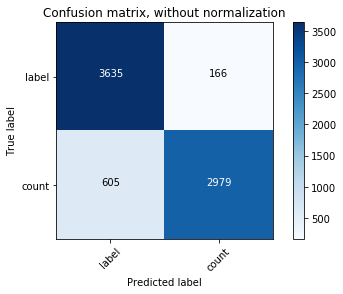

In [16]:
#Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_predictionAndLabels.select("label")
y_true = y_true.toPandas()
y_pred = test_predictionAndLabels.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp["label"])
cnf_matrix
#Plotting Results
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, title='Confusion matrix, without normalization')
plt.show()